In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import nltk
from nltk.corpus import gutenberg
nltk.download('punkt')
nltk.download('gutenberg')
import re
from sklearn.model_selection import train_test_split

#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chuck\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\chuck\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [3]:
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    #para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))



In [4]:
emma_paras[0:4]

['[ Emma by Jane Austen 1816 ]',
 'VOLUME I',
 'CHAPTER I',
 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']

# Semantics

With all the information we were able to pull out of the text, one thing we didn't really use was semantics- the *meaning* of the words and sentences.  Our supervised learning model 'knows' that Jane Austen tends to use the word 'lady' a lot in her writing, and it may know (if you included parts of speech as features) that 'lady' is a noun, but it doesn't know what a lady is.  There is nothing in our work on NLP so far that would allow a model to say whether 'queen' or 'car' is more similar to 'lady.' 

This severely limits the applicability of our NLP skills!  In the absence of semantic information, models can get tripped up on things like synonyms ('milady' and 'lady'). We could modify the spaCy dictionary to include 'lady' as the lemma of 'milady,' then use lemmas for all our analyses, but for this to be an effective approach we would have to go through our entire corpus and identify all synonyms for all words by hand. This approach would also discard subtle differences in the connotations of (words, concepts, ideas, or emotions associated with) 'lady' (elicits thoughts of formal manners and England) and 'milady' (elicits thoughts of medieval ages and Rennaissance Faires).  

Basically, language is complicated, and trying to explicitly model all the information encoded in language is nearly impossibly complicated.  Fortunately, unsupervised modeling techniques, and particularly unsupervised neural networks, are perfect for this kind of task.  Rather than us 'telling' the model how language works and what each sentence means, we can feed the model a corpus of text and have it 'learn' the rules by identifying recurring patterns within the corpus.  Then we can use the trained unsupervised model to understand new sentences as well.  

As with supervised NLP, unsupervised models are limited by their corpus- an unsupervised model trained on a medical database is unlikely to know that 'lady' and 'milady' are similar, just as a model trained on Jane Austen wouldn't catch that 'Ehler-Danlos Syndrome' and 'joint hypermobility' describe the same medical condition.  

In this assignment, we are going to introduce Latent Semantic Analysis.  In the next, we will discuss unsupervised neural network applications for NLP.  

# Converting sentences to vectors

Consider the following sentences:

1. "The best Monty Python sketch is the one about the dead parrot,  I laughed so hard."
2. "I laugh when I think about Python's Ministry of Silly Walks sketch, it is funny, funny, funny, the best!"
3. "Chocolate is the best ice cream dessert topping, with a great taste."
4. "The Lumberjack Song is the funniest Monty Python bit: I can't think of it without laughing."
5. "I would rather put strawberries on my ice cream for dessert, they have the best taste."
6. "The taste of caramel is a fantastic accompaniment to tasty mint ice cream."

As a human being, it's easy to see that the sentences involve two topics, comedy and ice cream.   One way to represent the sentences is in a term-document matrix, with a column for each sentence and a row for each word.  Ignoring the stop words 'the', 'is','and', 'a', 'of,','I', and 'about,', discarding words that occur only once, and reducing words like 'laughing' to their root form ('laugh'), the term-document matrix for these sentences would be:



| words     | 1 | 2 | 3 | 4 | 5 | 6 |
|-----------|---|---|---|---|---|---|
| Monty     | 1 | 0 | 0 | 1 | 0 | 0 |
| Python    | 1 | 1 | 0 | 1 | 0 | 0 |
| sketch    | 1 | 1 | 0 | 0 | 0 | 0 |
| laugh     | 1 | 1 | 0 | 1 | 0 | 0 |
| funny     | 0 | 3 | 0 | 1 | 0 | 0 |
| best      | 1 | 1 | 1 | 0 | 1 | 0 |
| ice cream | 0 | 0 | 1 | 0 | 1 | 1 |
| dessert   | 0 | 0 | 1 | 0 | 1 | 0 |
| taste     | 0 | 0 | 1 | 0 | 1 | 2 |

Note that we use the term 'document' to refer to the individual text chunks we are working with. It can sometimes mean sentences, sometimes paragraphs, and sometimes whole text files.  In our cases, each sentence is a document.  Also note that, contrary to how we usually operate, a term-document matrix has words as rows and documents as columns.

The comedy sentences use the words: Python (3), laugh (3), Monty (2), sketch (2), funny (2), and best (2).
The ice cream sentences use the words: ice cream (3), dessert (3), taste (3), and best (2).

The word 'best' stands out here- it appears in more sentences than any other word (4 of 6).  It is used equally to describe Monty Python and ice cream.  If we were to use this term-document matrix as-is to teach a computer to parse sentences, 'best' would end up as a significant identifier for both topics, and every time we gave the model a new sentence to identify that included 'best,' it would bring up both topics.  Not very useful.  To avoid this, we want to weight the matrix so that words that occur in many different sentences have lower weights than words that occur in fewer sentences.  We do want to put a floor on this though-- words that only occur once are totally useless for finding associations between sentences.  

Another word that stands out is 'funny', which appears more often in the comedy sentences than any other word.  This suggests that 'funny' is a very important word for defining the 'comedy' topic.  

# Quantifying documents: Collection and document frequencies

'Document frequency' counts how many sentences a word appears in.  'Collection frequency' counts how often a word appears, total, over all sentences.  Let's calculate the df and cf for our sentence set:

|    word       |df |cf| 
|-----------|---|---|
| Monty     | 2 | 2 | 
| Python    | 3 | 3 | 
| sketch    | 2 | 2 | 
| laugh     | 3 | 3 | 
| funny     | 2 | 4 | 
| best      | 4 | 4 | 
| ice cream | 3 | 3 | 
| dessert   | 2 | 2 | 
| taste     | 3 | 4 | 

# Penalizing Indiscriminate Words: Inverse Document Frequency

Now let's weight the document frequency so that words that occur less often (like 'sketch' and 'dessert') are more influential than words that occur a lot (like 'best').  We will calculate the ratio of total documents (N) divided by df, then take the log (base 2) of the ratio, to get our inverse document frequency number (idf) for each term (t):

$$idf_t=log \dfrac N{df_t}$$


|  word / value | df |cf| idf |
|-----------|---|---| ------|
| Monty     | 2 | 2 | 1.585 |
| Python    | 3 | 3 | 1 |
| sketch    | 2 | 2 | 1.585 |
| laugh     | 3 | 3 | 1 |
| funny     | 2 | 4 | 1.585 |
| best      | 4 | 4 | .585 |
| ice cream | 3 | 3 | 1 |
| dessert   | 2 | 2 | 1.585 |
| taste     | 3 | 4 | 1 |

The idf weights tell the model to consider 'best' as less important than other terms.  

# Term-frequency weights
The next piece of information to consider for our weights is how frequently a term appears within a sentence.  The word 'funny' appears three times in one sentence- it would be good if we were able to weight 'funny' so that the model knows that. We can accomplish this by creating unique weights for each sentence that combine the term frequency (how often a word appears within an individual document) with the idf, like so:

$$tf-idf_{t,d}=(tf_{t,d})(idf_t)$$

Now the term 'funny' in sentence 2, where it occurs three times, will be weighted more heavily than the term 'funny' in sentence 1, where it only occurs once.  If 'best' had appeared multiple times in one sentence, it would also have a higher weight for that sentence, but the weight would be reduced by the idf term that takes into account that 'best' is a pretty common word in our collection of sentences.

The tf_idf score will be highest for a term that occurs a lot within a small number of sentences, and lowest for a word that occurs in most or all sentences.  

Now we can represent each sentence as a vector made up of the tf-idf scores for each word:

|    word / sentence     | 1 | 2 | 3 | 
|-----------|---|---|---|
| Monty     | 1.585 | 0 | 0 |
| Python    | 1 | 1 | 0 | 
| sketch    | 1.585| 1.585 | 0 | 
| laugh     | 1 | 1 | 0 | 
| funny     | 0 | 4.755 | 0 | 
| best      | .585 | .585 | .585 | 
| ice cream | 0 | 0 | 1 | 
| dessert   | 0 | 0 | 1.585 | 
| taste     | 0 | 0 | 1 |



## Drill: tf-idf scores

Converting sentences into numeric vectors is fundamental for a lot of unsupervised NLP tasks.  To make sure you are solid on how these vectors work, please generate the vectors for the last three sentences.  If you are feeling uncertain, have your mentor walk you through it.

(solution for 4, 5, and 6:

4. 1.585, 1, 0, 1, 1.585, 0,0,0,0
5. 0,0,0,0,0, .585, 1, 1.585, 1
6. 0,0,0,0,0,0, 1, 0, 2)



In [6]:
Monty     = [1 , 0 , 0 , 1 , 0 , 0]
Python    = [1 , 1 , 0 , 1 , 0 , 0] 
sketch    = [1 , 1 , 0 , 0 , 0 , 0] 
laugh     = [1 , 1 , 0 , 1 , 0 , 0] 
funny     = [0 , 3 , 0 , 1 , 0 , 0] 
best      = [1 , 1 , 1 , 0 , 1 , 0] 
icecream  = [0 , 0 , 1 , 0 , 1 , 1] 
dessert   = [0 , 0 , 1 , 0 , 1 , 0] 
taste     = [0 , 0 , 1 , 0 , 1 , 2] 
keys = ['Monty','Python','sketch','laugh','funny','best','icecream','dessert','taste'] 
A = [eval(k )for k in keys]

In [7]:
# the term frequency per  6 documents, document frequency, collection frequency, inverse document frequency
mx1 = pd.DataFrame(A, index=keys, columns=range(1,7))
cf = pd.DataFrame(mx1.sum(axis=1), index=keys, columns=['cf'])
df  = pd.DataFrame([len(np.where(mx1.loc[k] != 0)[0]) for k in keys], index=keys, columns=['df'])
mx2 = pd.concat([mx1, cf, df], axis=1)
mx2['idf'] = mx2.df.apply(lambda x : np.log2((len(mx1.loc['Monty'])) / x))
mx2

,1,2,3,4,5,6,cf,df,idf
Monty,1,0,0,1,0,0,2,2,1.584963
Python,1,1,0,1,0,0,3,3,1.000000
sketch,1,1,0,0,0,0,2,2,1.584963
laugh,1,1,0,1,0,0,3,3,1.000000
funny,0,3,0,1,0,0,4,2,1.584963
best,1,1,1,0,1,0,4,4,0.584963
icecream,0,0,1,0,1,1,3,3,1.000000
dessert,0,0,1,0,1,0,2,2,1.584963
taste,0,0,1,0,1,2,4,3,1.000000


In [8]:
# the tf-idf weighting values for 6 documents
tf_wght = [mx1.loc[k] * mx2.loc[k,'idf'] for (i,k) in enumerate(keys)]
mx3 = pd.DataFrame(tf_wght, index=keys)
mx3

,1,2,3,4,5,6
Monty,1.584963,0.000000,0.000000,1.584963,0.000000,0.0
Python,1.000000,1.000000,0.000000,1.000000,0.000000,0.0
sketch,1.584963,1.584963,0.000000,0.000000,0.000000,0.0
laugh,1.000000,1.000000,0.000000,1.000000,0.000000,0.0
funny,0.000000,4.754888,0.000000,1.584963,0.000000,0.0
best,0.584963,0.584963,0.584963,0.000000,0.584963,0.0
icecream,0.000000,0.000000,1.000000,0.000000,1.000000,1.0
dessert,0.000000,0.000000,1.584963,0.000000,1.584963,0.0
taste,0.000000,0.000000,1.000000,0.000000,1.000000,2.0


You can think of the tf-idf vectors as a 'translation' from human-readable language to computer-usable numeric form.  Some information is inevitably lost in translation, and the usefulness of any model we build from here on out depends on the decisions we made during the translation step.  Possible decision-points include:

* Which stop words to include or exclude
* Should we use phrases ('Monty Python' instead of 'Monty' and 'Python') as terms
* The threshold for infrequent words: Here, we excluded words that only occurred once.  In longer documents, it may be a good idea to set a higher threshold.
* How many terms to keep.  We kept all the terms that fit our criteria (not a stop word, occurred more than once), but for bigger document collections or longer documents, this may create unfeasibly long vectors.  We may want to decide to only keep the 10,000 words with the highest collection frequency scores, for example.

# Vector Space Model

Our vector representation of the text is referred to as a Vector Space Model.  We can use this representation to compute the similarity between our sentences and a new phrase or sentence- this method is often used by search engines to match a query to possible results.  

By now, you've had some practice thinking of data as existing in multi-dimensional space.  Our sentences exist in an n-dimensional space where n is equal to the number of terms in our term-document matrix.  To compute the similarity of our sentences to a new sentence, we transform the new sentence into a vector and place it in the space.  We can then calculate how different the angles are for our original vectors and the new vector, and identify the vector whose angle is closest to the new vector.  Typically this is done by calculating the cosine of the angle between the vectors.  If the two vectors are identical, the angle between them will be 0° and the cosine will be 1.  If the two vectors are orthogonal, with an angle of 90°, the cosine will be 0.  

If we were running a search query, then, we would return sentences that were most similar to the query sentence, ordered from the highest similarity score (cosine) to the lowest.  Pretty handy!

# Latent Semantic Analysis

Cool as this is, there are limitations to the VSM.  In particular, because it treats each word as distinct from every other word, it can run aground on *synonyms* (treating words that mean the same thing as though they are different, like big and large).  Also, because it treats all occurrences of a word as the same regardless of context, it can run aground on *polysemy*, where there are different meanings attached to the same word: 'I need a break' vs 'I break things.'  In addition, VSM has difficulty with very large documents because the more words a document has, the more opportunities it has to diverge from other documents in the space, making it difficult to see similarities.

A solution to this problem is to reduce our tf-idf-weighted term-document matrix into a lower-dimensional space, that is, to express the information in the matrix using fewer rows by combining the information from multiple terms into one new row/dimension.  We do this using Principal Components Analysis, which you may recall from [an earlier assignment](https://courses.thinkful.com/data-201v1/assignment/2.1.6).  

So Latent Semantic Analysis (also called Latent Semantic Indexing) is the process of applying PCA to a tf-idf term-document matrix.  What we get, in the end, is clusters of terms that presumably reflect a topic.  Each document will get a score for each topic, with higher scores indicating that the document is relevant to the topic.  Documents can pertain to more than one topic.

LSA is handy when your corpus is too large to topically annotate by hand, or when you don't know what topics characterize your documents.  It is also useful as a way of creating features to be used in other models.

Let's try it out!  Once again, we'll use the gutenberg corpus.   This time, we'll focus on comparing paragraphs within Emma by Jane Austen.

In [1]:
import nltk
from nltk.corpus import gutenberg
nltk.download('punkt')
nltk.download('gutenberg')
import re
from sklearn.model_selection import train_test_split

#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chuck\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\chuck\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


# tfidf in sklearn

Happily for us, sklearn has a tfidf function that will do all our heavy lifting.  It also has a [very long list of stop words](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/stop_words.py).  Since we're going to be doing dimension reduction later on anyway, let's keep all the words for now.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [3]:
emma_paras_tfidf.shape

(2371, 1948)

# Dimension reduction
Okay, now we have our vectors, with one vector per paragraph.  It's time to do some dimension reduction.  We use the Singular Value Decomposition (SVD) function from sklearn rather than PCA because we don't want to mean-center our variables (and thus lose sparsity):

In [11]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])




Percent variance captured by all components: 45.21533045555969
Component 0:
" Oh !     0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !     0.999289
Oh !       0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !"    0.999289
" Oh !     0.999289
" Oh !     0.999289
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.634828
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.590807
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.561310
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elto

From gazing at the most representative sample paragraphs, it appears that component 0 targets the exclamation 'Oh!', component 1 seems to largely involve critical dialogue directed at or about the main character Emma, component 2 is chapter headings, component 3 is exclamations involving 'Ah!, and component 4 involves actions by or directly related to Emma.

What fun! 

# Sentence similarity

We can also look at how similar various sentences are to one another.  For example, here are the similarity scores (as a heatmap) of the first 10 sentences in the training set:


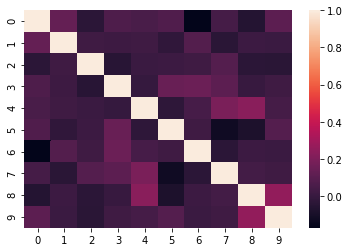

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [12]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


Not much similarity at all except between sentences 8 and 9, both of which seem to describe people getting along well.

# Drill 0: Test set

Now it's your turn: Apply our LSA model to the test set.  Does it identify similar sentences for components 0 through 4?  

In [15]:
X_test_lsa = lsa.fit_transform(X_test_tfidf)
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 49.36135095181277
Component 0:
" Oh !       0.99992
" Oh !       0.99992
" Oh !       0.99992
" Oh no !    0.99992
" Oh !       0.99992
" Oh !       0.99992
" Oh !       0.99992
" Oh !       0.99992
" Oh !"      0.99992
" Oh !       0.99992
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                             0.612701
After tea , Mr . and Mrs . Weston , and Mr . Elton sat down with Mr . Woodhouse to cards .                                                                                                                                             

# Drill 1: Tweaking tf-idf

Go back up to the code where we originally translated the text from words to numbers.  There are a lot of decision-points here, from the stop list to the thresholds for inclusion and exclusion, and many others as well.  We also didn't integrate spaCy, and so don't have info on lemmas or Named Entities.  Change things up a few times and see how that affects the results of the LSA.  Write up your observations and share them with your mentor.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import ParameterGrid

In [18]:
# list of 9 parameter dicts
prm =list(ParameterGrid({'max_df': [0.4,0.5,0.6],'min_df': [2,3,4], 'stop_words': ['english'],
                         'lowercase':[True], 'use_idf':[True], 'norm':[u'l2'], 'smooth_idf':[True]}))

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             =, 
                             , #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             ,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [7]:
X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])
#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)
#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()
#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])


LSA is one of many unsupervised methods that can be applied to text data.  There will be opportunities later to dive more deeply into this topic and encounter other methods.

Although we have presented LSA as an unsupervised method, it can also be used to prepare text data for classification in supervised learning.  In that case, the goal would be to use LSA to arrive at a smaller set of features that can be used to build a supervised model that will classify text into pre-labelled categories.

LSA isn't perfect- while it is good for dealing with synonyms, it cannot handle polysemy.  For that, we will need to try out a neural network approach.

This assignment has a lot of moving parts- text processing, tf-idf, using single value decomposition on text, and finally interpreting the results of the LSA.  Make sure to spend enough time playing with the code to feel comfortable with all of these aspects before moving on.